In [1]:
#Create a cluster
import ipyparallel as ipp

# Create an MPI cluster with 8 engines
nproc = 8 #<-- Para usar as 8 GPUS da DGX
cluster = ipp.Cluster(engines="mpi", n=nproc)

# Start and connect to the cluster
rc = cluster.start_and_connect_sync()

# Enable IPython magics for parallel processing
rc[:].activate()

Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/8 [00:00<?, ?engine/s]

A partir daqui use a mágica ``%%px --block`` para executar no cluster criado

In [2]:
%%px --block

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rockverse as rv
from rockverse.optimize import gaussian_val

samples = pd.read_csv('/nethome/drp2/servicos/ROCHA_DIGITAL/CERD_UFRJ/Rodolfo/rodolfo.csv')

######################################
# Input parameters
specs = {
    #'sample': 'V017973H',
    'resolution': 41740,
    'bhc': True,
    'acquisition': 'long',
}
energies = (160, 220)

group_name = 'Test1' # Directory name

overwrite = True # Overwite directory by default?

workdir = '/nethome/drp2/servicos/ROCHA_DIGITAL/CERD_UFRJ/Rodolfo/'
#####################################

#Get sample paths
sample_set = samples
for k, v in specs.items():
    sample_set = sample_set[sample_set[k] == v]

lowE_sample_info = sample_set[sample_set['energy']==min(energies)]
highE_sample_info = sample_set[sample_set['energy']==max(energies)]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

# Cria o grupo e carrega as imagens

In [3]:
%%px --block

dectgroup = rv.open(store=os.path.join(workdir, group_name))


# Create the Dual Energy CT group
dectgroup = rv.dualenergyct.create_group(
    store=os.path.join(workdir, group_name),
    overwrite=overwrite)

#Parâmetros poderiam estar naquele tabelão...
shape = (1404, 1412, 1266)
dtype = '<i2' # little-endian 16bit signed integer
chunks = (200, 200, 200)
voxel_length = (1, 1, 1)


# Import the low energy image
dectgroup.copy_image(
    name='lowECT',
    image=rv.voxel_image.import_raw(
        rawfile=os.path.join(workdir,  lowE_sample_info['path'].iloc[0].split(os.sep)[-1]) + '_import.raw',
        shape=shape,                         #<- From metadata, image size
        chunks=chunks,                       #<- Our choice of chunk size will give a 2x2x2 chunk grid
        dtype=dtype,                         #<- From metadata, little-endian 16-bit signed integer
        offset=0,                            #<- From metadata
        voxel_length=voxel_length,
        voxel_unit='u.a.',                   #<- From metadata
        raw_file_order='F',                  #<- Fortran file order
        field_name='Low energy attenuation', #<- Our choice for field name (X-ray attenuation)
        field_unit='',                       #<- field units
        description='Low energy X-ray CT attenuation',
        overwrite=True                       #<- Overwrite if file exists in disk
        )
    )

# Import the high energy image
dectgroup.copy_image(
    name='highECT',
    image=rv.voxel_image.import_raw(
        rawfile=os.path.join(workdir,  highE_sample_info['path'].iloc[0].split(os.sep)[-1]) + '_import.raw',
        shape=shape,                         #<- From metadata, image size
        chunks=chunks,                       #<- Our choice of chunk size will give a 2x2x2 chunk grid
        dtype=dtype,                         #<- From metadata, little-endian 16-bit signed integer
        offset=0,                            #<- From metadata
        voxel_length=voxel_length,
        voxel_unit='u.a.',                   #<- From metadata
        raw_file_order='F',                  #<- Fortran file order
        field_name='High energy attenuation', #<- Our choice for field name (X-ray attenuation)
        field_unit='',                       #<- field units
        description='High energy X-ray CT attenuation',
        overwrite=True                       #<- Overwrite if file exists in disk
        )
    )

# Optional: Import segmentation
dectgroup.copy_image(
    name='segmentation',
    image=rv.voxel_image.import_raw(
        rawfile=os.path.join(workdir,  lowE_sample_info['path'].iloc[0].split(os.sep)[-1]) + '_seed.raw',
        shape=shape,                         #<- From metadata, image size
        chunks=chunks,                       #<- Our choice of chunk size will give a 2x2x2 chunk grid
        dtype='|u1',                          #<- 8-bit unsigned integer
        offset=0,                            #<- From metadata
        voxel_length=voxel_length,
        voxel_unit='u.a.',                   #<- From metadata
        raw_file_order='F',                  #<- Fortran file order
        field_name='Segmentation',
        field_unit='',                       #<- field units
        description='Segmentation',
        overwrite=True                       #<- Overwrite if file exists in disk
        )
    )

# mask out empty space
dectgroup.create_mask(fill_value=False, overwrite=True)
dectgroup.mask.math(value=True,
                    op='set',
                    segmentation=dectgroup.segmentation,
                    phases=(0,))


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[stdout:0] [2025-02-24 20:44:45] (Low energy attenuation) Importing raw file: 100% 448/448 [00:12<00:00, 34.79chunk/s]
[2025-02-24 20:44:58] Copying: 100% 448/448 [01:35<00:00,  4.71chunk/s]
[2025-02-24 20:46:33] (High energy attenuation) Importing raw file: 100% 448/448 [00:12<00:00, 37.26chunk/s]
[2025-02-24 20:46:45] Copying: 100% 448/448 [01:30<00:00,  4.93chunk/s]
[2025-02-24 20:48:16] (Segmentation) Importing raw file: 100% 448/448 [00:09<00:00, 48.68chunk/s]
[2025-02-24 20:48:26] Copying: 100% 448/448 [00:37<00:00, 11.85chunk/s]
[2025-02-24 20:49:05] (mask) Set: 100% 448/448 [00:06<00:00, 68.23chunk/s] 


[stderr:7] /estgf_dados/P_D/GOB7/mambaforge/envs/rockverse-zarr3/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 25 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/estgf_dados/P_D/GOB7/mambaforge/envs/rockverse-zarr3/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 117 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/estgf_dados/P_D/GOB7/mambaforge/envs/rockverse-zarr3/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 9 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


# Opcional: Visualização das imagens

[stdout:0] [2025-02-24 20:49:13] Histogram Low energy attenuation (min/max): 100% 448/448 [00:08<00:00, 54.23chunk/s]
[2025-02-24 20:49:22] Histogram Low energy attenuation (counting voxels): 100% 448/448 [00:26<00:00, 16.81chunk/s]
[2025-02-24 20:49:58] Histogram Low energy attenuation (min/max): 100% 448/448 [00:02<00:00, 200.48chunk/s]
[2025-02-24 20:50:01] Histogram Low energy attenuation (counting voxels): 100% 448/448 [00:26<00:00, 17.12chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

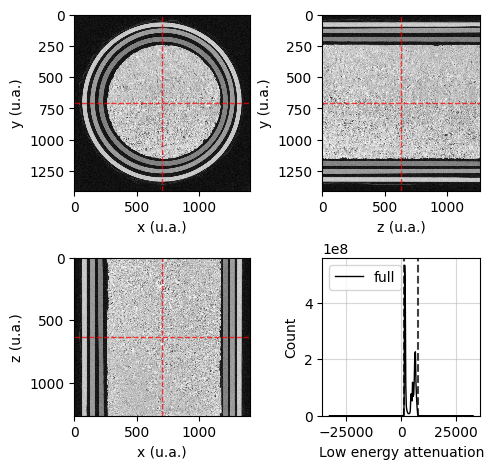

[output:0]

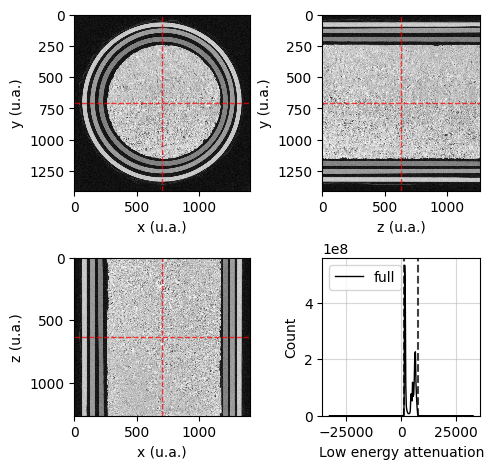

In [ ]:
%%px --block

lowE_viewer = rv.OrthogonalViewer(image=dectgroup.lowECT)
highE_viewer = rv.OrthogonalViewer(image=dectgroup.lowECT)

if rv.mpi_rank != 0:
    plt.close(lowE_viewer.figure)
    plt.close(highE_viewer.figure)

# Coloca as info dos calibradores

In [5]:
%%px --block

### Ar ---------------------------------------------------
ind = 0
dectgroup.calibration_material[ind].description = 'Ar'

m = 0
s = 0.01
x = np.linspace(m-3.5*s, m+3.5*s, 200)
dectgroup.calibration_material[ind].lowE_pdf = (x, gaussian_val((1, m, s), x))

m = 0
s = 0.01
x = np.linspace(m-3.5*s, m+3.5*s, 200)
dectgroup.calibration_material[ind].highE_pdf = (x, gaussian_val((1, m, s), x))



### Alumínio --------------------------------------------------
ind = 1
dectgroup.calibration_material[ind].description = 'Alumínio'
dectgroup.calibration_material[ind].bulk_density = 2.7
dectgroup.calibration_material[ind].composition = {'Al': 1}

m = lowE_sample_info['mean_aluminio'].iloc[0]
s = lowE_sample_info['desv_aluminio'].iloc[0]
x = np.linspace(m-3.5*s, m+3.5*s, 200)
dectgroup.calibration_material[ind].lowE_pdf = (x, gaussian_val((1, m, s), x))

m = highE_sample_info['mean_aluminio'].iloc[0]
s = highE_sample_info['desv_aluminio'].iloc[0]
x = np.linspace(m-3.5*s, m+3.5*s, 200)
dectgroup.calibration_material[ind].highE_pdf = (x, gaussian_val((1, m, s), x))




### Teflon --------------------------------------------------
ind = 2
dectgroup.calibration_material[ind].description = 'Teflon'
dectgroup.calibration_material[ind].bulk_density = 2.2
dectgroup.calibration_material[ind].composition = {'C': 2, 'F': 4}

m = lowE_sample_info['mean_teflon'].iloc[0]
s = lowE_sample_info['desv_teflon'].iloc[0]
x = np.linspace(m-3.5*s, m+3.5*s, 200)
dectgroup.calibration_material[ind].lowE_pdf = (x, gaussian_val((1, m, s), x))

m = highE_sample_info['mean_teflon'].iloc[0]
s = highE_sample_info['desv_teflon'].iloc[0]
x = np.linspace(m-3.5*s, m+3.5*s, 200)
dectgroup.calibration_material[ind].highE_pdf = (x, gaussian_val((1, m, s), x))



### Sílica --------------------------------------------------
ind = 3
dectgroup.calibration_material[ind].description = 'SiO2'
dectgroup.calibration_material[ind].bulk_density = 2.2
dectgroup.calibration_material[ind].composition = {'Si': 1, 'O': 2}

m = lowE_sample_info['mean_quartzo'].iloc[0]
s = lowE_sample_info['desv_quartzo'].iloc[0]
x = np.linspace(m-3.5*s, m+3.5*s, 200)
dectgroup.calibration_material[ind].lowE_pdf = (x, gaussian_val((1, m, s), x))

m = highE_sample_info['mean_quartzo'].iloc[0]
s = highE_sample_info['desv_quartzo'].iloc[0]
x = np.linspace(m-3.5*s, m+3.5*s, 200)
dectgroup.calibration_material[ind].highE_pdf = (x, gaussian_val((1, m, s), x))

# Executando a inversão nesse mini cluster local

In [ ]:
%%px --block
dectgroup.run(restart=True)

[stdout:0] [2025-02-24 20:50:41] Hashing Low energy attenuation: 100% 448/448 [00:03<00:00, 140.69chunk/s]
[2025-02-24 20:50:44] Hashing High energy attenuation: 100% 448/448 [00:09<00:00, 48.40chunk/s]
[2025-02-24 20:50:54] Hashing mask: 100% 448/448 [00:01<00:00, 252.09chunk/s]
[2025-02-24 20:50:56] Hashing Segmentation: 100% 448/448 [00:01<00:00, 300.46chunk/s]
[2025-02-24 20:51:10] Generating inversion coefficients: 100% 99998/100000 [01:06<00:00, 1493.16/s]
[2025-02-24 20:52:17] Creating output images: 100% 11/11 [00:00<00:00, 36.82it/s]
[2025-02-24 20:52:17] Counting voxels: 100% 448/448 [00:35<00:00, 12.49chunk/s]
[2025-02-24 20:52:53] rho/Z inversion (chunk 1/448):   0% 5450/1462151314 [00:43<3008:07:28, 135.02voxel/s]

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

# Se quiser jogar no cluster

Faça as configurações iniciais acima e use esses scripts

## Bash script:

```bash
#!/bin/bash
#SBATCH -J awesome_job_name
#SBATCH --nodes=2
#SBATCH --partition <your_partition>
#SBATCH --gres=gpu:16
#SBATCH --ntasks-per-node=256
#SBATCH --output=outputlog
#SBATCH --chdir=/path/to/workdir

conda activate you_environment_with_rockverse1.0
mpirun python3 ./run.py 
```

## Python script

```python
import rockverse as rv
dectgroup = rv.open(r'/path/to/dual_energy_ct/group')
dectgroup.run()
```